### Task 1 Basic Seting on ResNet34

In [1]:
# Install & Import Libraries

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import json
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [2]:
# Load Pretrained ResNet-34 Model

resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Load and preprocess ImageNet-like test dataset
Normalize using ImageNet stats, mount Google Drive, and load images with labels from specified path

In [3]:
# Load and Preprocess Data

# Normalization parameters for ImageNet
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define preprocessing
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Mount Google Drive to access dataset if uploaded there
from google.colab import drive
drive.mount('/content/drive')

# TODO: Change path below to your test dataset location
dataset_path = "/content/drive/MyDrive/master year 1 section 2/deep learning/Project 3/TestDataSet/TestDataSet"
json_path = "/content/drive/MyDrive/master year 1 section 2/deep learning/Project 3/TestDataSet/TestDataSet/labels_list.json"  # Path to labels file

# Load dataset
test_dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load label mapping
Map dataset class indices to true ImageNet label indices using a JSON file.

In [6]:
# Load Label Mapping (.json file)

with open(json_path, 'r') as f:
    label_list = json.load(f)

# Map ImageFolder index (0 to 99) → true ImageNet index (e.g., 401 to 500)
folder_idx_to_imagenet_idx = {
    i: int(entry.split(':')[0]) for i, entry in enumerate(label_list)
}

# Evaluate Top-1 and Top-5 accuracy
Compare model predictions with true ImageNet labels and compute Top-1 and Top-5 accuracy on the test set.

In [7]:
# Evaluate Top-1 and Top-5 Accuracy

top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Map ImageFolder indices (0–99) to true ImageNet label indices (401–500)
        true_labels = torch.tensor([folder_idx_to_imagenet_idx[label.item()] for label in labels]).to(device)

        # Forward pass through the model
        outputs = resnet34(images)

        # Get Top-1 prediction
        _, top1_preds = torch.max(outputs, dim=1)

        # Get Top-5 predictions
        top5_preds = torch.topk(outputs, k=5, dim=1).indices

        # Count correct Top-1 predictions
        top1_correct += (top1_preds == true_labels).sum().item()

        # Count correct Top-5 predictions
        for i in range(len(true_labels)):
            if true_labels[i] in top5_preds[i]:
                top5_correct += 1

        total += labels.size(0)

# Print accuracy results
print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


100%|██████████| 16/16 [00:01<00:00, 10.15it/s]

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


### Task 2 FSGM - Pixel wise attack
# Adversarial Evaluation with FGSM on ResNet-34
Install libraries, load pretrained ResNet-34 and test dataset. Normalize inputs, apply FGSM attack (ε = 0.02), and compute Top-1 and Top-5 accuracy on adversarial examples.

In [22]:
# Install & Import Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import json
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import torchvision.utils as vutils

# Check Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load Pretrained ResNet-34 Model
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().to(device)

# Normalization parameters based on ImageNet statistics
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define normalization and unnormalization transforms
normalize_transform = transforms.Normalize(mean=mean_norms, std=std_norms)
unnormalize_transform = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean_norms, std_norms)],
    std=[1/s for s in std_norms]
)

# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

# Define dataset and label mapping paths
dataset_path = "/content/drive/MyDrive/master year 1 section 2/deep learning/Project 3/TestDataSet/TestDataSet"
json_path = "/content/drive/MyDrive/master year 1 section 2/deep learning/Project 3/TestDataSet/TestDataSet/labels_list.json"

# Load dataset without normalization (applied later)
plain_transform = transforms.ToTensor()
test_dataset = ImageFolder(root=dataset_path, transform=plain_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load mapping from folder indices to true ImageNet label indices
with open(json_path, 'r') as f:
    label_list = json.load(f)

folder_idx_to_imagenet_idx = {
    i: int(entry.split(':')[0]) for i, entry in enumerate(label_list)
}

# Function to Apply FGSM
def fgsm_attack(image, label, model, epsilon):
    # Enable gradient computation for input image
    image.requires_grad = True

    # Normalize image and compute loss
    norm_img = normalize_transform(image)
    output = model(norm_img.unsqueeze(0))
    loss = F.cross_entropy(output, label.unsqueeze(0))

    model.zero_grad()
    loss.backward()

    # Apply gradient sign to create adversarial example
    data_grad = image.grad.data
    perturbed = image + epsilon * data_grad.sign()
    perturbed = torch.clamp(perturbed, 0, 1)

    return perturbed.detach()

# FGSM Evaluation Loop
epsilon = 0.02
adv_top1_correct = 0
adv_top5_correct = 0
total = 0
adv_examples = []

print("Generating Adversarial Test Set...")

for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Convert labels to true ImageNet indices
    true_labels = torch.tensor([folder_idx_to_imagenet_idx[label.item()] for label in labels]).to(device)

    batch_adv = []
    for i in range(images.size(0)):
        # Generate adversarial example for each image in the batch
        img = images[i].clone().detach()
        lbl = true_labels[i].clone().detach()
        adv_img = fgsm_attack(img, lbl, resnet34, epsilon)
        batch_adv.append(adv_img)

    # Stack and normalize the batch of adversarial examples
    adv_batch = torch.stack(batch_adv).to(device)
    norm_adv_batch = normalize_transform(adv_batch)
    outputs = resnet34(norm_adv_batch)

    # Get Top-1 and Top-5 predictions
    _, top1_preds = outputs.max(1)
    top5_preds = torch.topk(outputs, 5, dim=1).indices

    # Update accuracy counts
    adv_top1_correct += (top1_preds == true_labels).sum().item()
    for i in range(len(true_labels)):
        if true_labels[i] in top5_preds[i]:
            adv_top5_correct += 1

    total += len(labels)
    adv_examples.extend(batch_adv)

# Print final evaluation results
print(f"[FGSM] Top-1 Accuracy: {100 * adv_top1_correct / total:.2f}%")
print(f"[FGSM] Top-5 Accuracy: {100 * adv_top5_correct / total:.2f}%")


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generating Adversarial Test Set...


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]

[FGSM] Top-1 Accuracy: 3.60%
[FGSM] Top-5 Accuracy: 20.80%


save Adversarial Test Set

In [23]:
# save as AdversarialTestSet1
save_dir = "/content/drive/MyDrive/FGSM_AdversarialTestSet1"
os.makedirs(save_dir, exist_ok=True)

for idx, img in enumerate(adv_examples):
    vutils.save_image(img, os.path.join(save_dir, f"img_{idx:04d}.png"))

### Task 3 Improved attacks - PGD attack
# Evaluate PGD adversarial robustness
Apply a multi-step PGD attack (ε = 0.02, α = 0.005, 10 steps) and compute Top-1 and Top-5 accuracy on adversarial images.

In [48]:
# PGD Attack Function

def pgd_attack(image, label, model, epsilon=0.02, alpha=0.005, num_steps=10):
    # Clone the original image and prepare for gradient updates
    orig_image = image.clone().detach()
    perturbed = orig_image.clone().detach()
    perturbed.requires_grad = True

    for _ in range(num_steps):
        # Forward pass with normalized input
        output = model(normalize_transform(perturbed.unsqueeze(0)))
        loss = F.cross_entropy(output, label.unsqueeze(0))

        model.zero_grad()
        loss.backward()

        # Compute gradient sign and apply perturbation
        grad_sign = perturbed.grad.data.sign()
        perturbed = perturbed + alpha * grad_sign

        # Clip perturbation within the allowed epsilon-ball
        perturbation = torch.clamp(perturbed - orig_image, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(orig_image + perturbation, 0, 1).detach_()
        perturbed.requires_grad = True

    return perturbed.detach()


# PGD Evaluation Loop

pgd_top1_correct = 0
pgd_top5_correct = 0
total = 0
pgd_images = []
original_images = []

for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Convert class indices to true ImageNet labels
    true_labels = torch.tensor([folder_idx_to_imagenet_idx[label.item()] for label in labels]).to(device)

    pgd_batch = []
    for i in range(images.size(0)):
        # Generate adversarial example using PGD
        adv = pgd_attack(images[i], true_labels[i], resnet34,
                         epsilon=0.02, alpha=0.005, num_steps=10)
        pgd_batch.append(adv)

    # Stack and normalize the batch of adversarial images
    pgd_batch = torch.stack(pgd_batch)
    normed_batch = torch.stack([normalize_transform(img) for img in pgd_batch]).to(device)

    # Run inference on adversarial examples
    outputs = resnet34(normed_batch)
    _, top1_preds = torch.max(outputs, dim=1)
    top5_preds = torch.topk(outputs, k=5, dim=1).indices

    # Compute accuracy metrics
    pgd_top1_correct += (top1_preds == true_labels).sum().item()
    for i in range(len(true_labels)):
        if true_labels[i] in top5_preds[i]:
            pgd_top5_correct += 1

    total += len(labels)
    pgd_images.extend(pgd_batch.cpu())
    original_images.extend(images.cpu())

# Report final results
print(f"[PGD] Top-1 Accuracy: {100 * pgd_top1_correct / total:.2f}%")
print(f"[PGD] Top-5 Accuracy: {100 * pgd_top5_correct / total:.2f}%")


100%|██████████| 16/16 [01:14<00:00,  4.67s/it]

[PGD] Top-1 Accuracy: 0.00%
[PGD] Top-5 Accuracy: 1.60%


Visualize performance for 3 example images.

Showing 3 PGD Adversarial Examples:


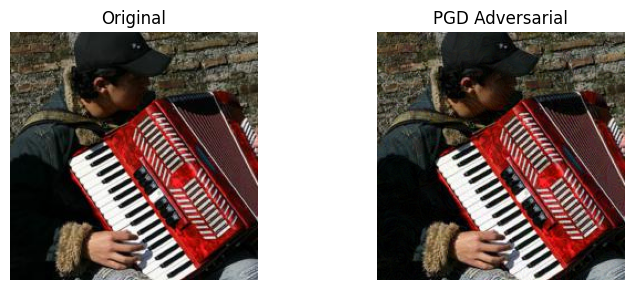

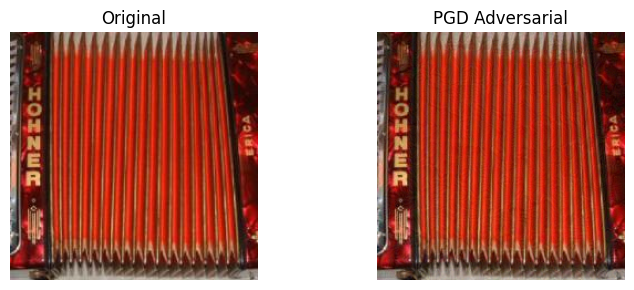

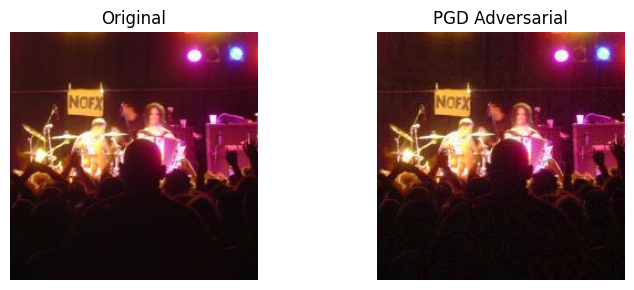

In [56]:
# Show Sample Visualizations

print("Showing 3 PGD Adversarial Examples:")
for i in range(3):
    orig = original_images[i]
    adv = pgd_images[i]

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].imshow(np.clip(np.transpose(orig.numpy(), (1, 2, 0)), 0, 1))
    axs[0].set_title("Original")
    axs[1].imshow(np.clip(np.transpose(adv.numpy(), (1, 2, 0)), 0, 1))
    axs[1].set_title("PGD Adversarial")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [50]:
# Save Images to Drive
save_dir = "/content/drive/MyDrive/PGD_AdversarialTestSet2"
os.makedirs(save_dir, exist_ok=True)

orig_dir = os.path.join(save_dir, "originals")
adv_dir = os.path.join(save_dir, "adversarials")
os.makedirs(orig_dir, exist_ok=True)
os.makedirs(adv_dir, exist_ok=True)

for idx, (orig, adv) in enumerate(zip(original_images, pgd_images)):
    vutils.save_image(orig, os.path.join(orig_dir, f"img_{idx:04d}.png"))
    vutils.save_image(adv, os.path.join(adv_dir, f"img_{idx:04d}.png"))

### Task 4: Patch attacks
# Evaluate Patch-PGD adversarial robustness
Apply PGD restricted to a random 32×32 patch (ε = 0.3, α = 0.01, 20 steps) and compute Top-1 and Top-5 accuracy on adversarial images.

In [57]:
import random

def patch_pgd_attack(image, label, model, patch_size=32, epsilon=0.3, alpha=0.01, num_steps=20):
    # Performs PGD attack constrained to a random 32×32 patch.
    image = image.clone().detach()
    orig_image = image.clone().detach()
    perturbed = image.clone().detach()
    perturbed.requires_grad = True

    # Randomly select the top-left corner of the patch
    c, h, w = image.shape
    x = random.randint(0, w - patch_size)
    y = random.randint(0, h - patch_size)

    # Define normalization consistent with ImageNet preprocessing
    norm = transforms.Normalize(mean=mean_norms, std=std_norms)

    for _ in range(num_steps):
        # Forward pass through the model using normalized input
        normed = norm(perturbed.unsqueeze(0))
        output = model(normed)
        loss = F.cross_entropy(output, label.unsqueeze(0))

        model.zero_grad()
        loss.backward()

        # Compute gradient only within the selected patch
        grad = perturbed.grad.data
        patch_grad = torch.zeros_like(grad)
        patch_grad[:, y:y+patch_size, x:x+patch_size] = grad[:, y:y+patch_size, x:x+patch_size].sign()

        # Update perturbation and clip it within epsilon bounds
        perturbed = perturbed + alpha * patch_grad
        perturbation = torch.clamp(perturbed - orig_image, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(orig_image + perturbation, 0, 1).detach_()
        perturbed.requires_grad = True

    return perturbed.detach()


In [58]:
patch_top1_correct = 0
patch_top5_correct = 0
total = 0
patch_adv_images = []

for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Map labels to true ImageNet indices
    true_labels = torch.tensor([folder_idx_to_imagenet_idx[label.item()] for label in labels]).to(device)

    patch_batch = []
    for i in range(images.size(0)):
        # Generate adversarial image using localized PGD (patch attack)
        adv = patch_pgd_attack(
            images[i].clone(),
            true_labels[i],
            resnet34,
            patch_size=32,
            epsilon=0.3,
            alpha=0.01,
            num_steps=20
        )
        patch_batch.append(adv)

    # Stack the batch of adversarial examples and normalize
    patch_batch = torch.stack(patch_batch)
    normed_batch = torch.stack([normalize_transform(img) for img in patch_batch]).to(device)

    # Forward pass through the model
    outputs = resnet34(normed_batch)

    # Compute Top-1 and Top-5 predictions
    _, top1_preds = outputs.max(1)
    top5_preds = torch.topk(outputs, 5, dim=1).indices

    # Update accuracy counters
    patch_top1_correct += (top1_preds == true_labels).sum().item()
    for i in range(len(true_labels)):
        if true_labels[i] in top5_preds[i]:
            patch_top5_correct += 1

    total += len(labels)
    patch_adv_images.extend(patch_batch.cpu())

# Print final accuracy after Patch-PGD attack
print(f"[Patch-PGD] Top-1 Accuracy: {100 * patch_top1_correct / total:.2f}%")
print(f"[Patch-PGD] Top-5 Accuracy: {100 * patch_top5_correct / total:.2f}%")


100%|██████████| 16/16 [02:29<00:00,  9.34s/it]

[Patch-PGD] Top-1 Accuracy: 36.20%
[Patch-PGD] Top-5 Accuracy: 73.60%


Plot the 3 examples: original match adversarial

Showing 3 Patch Adversarial Examples:


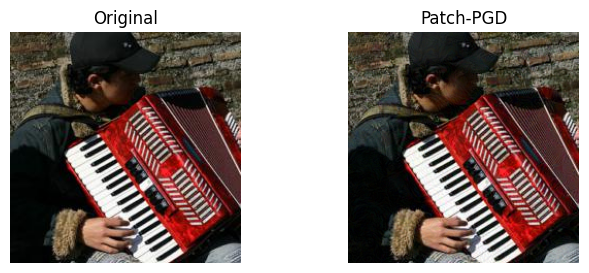

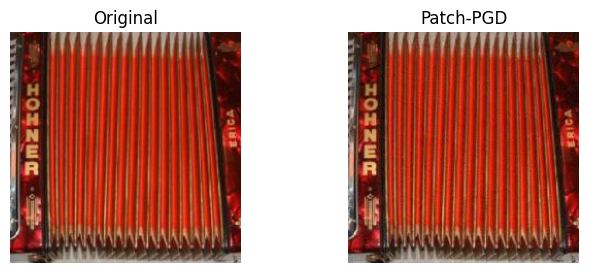

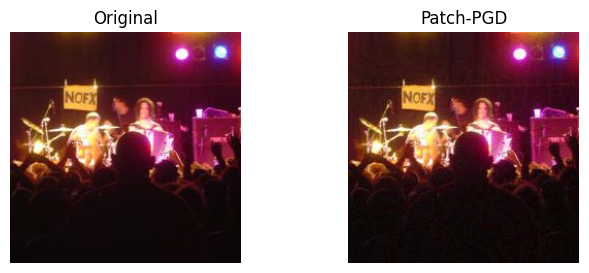

In [59]:
print("Showing 3 Patch Adversarial Examples:")
for i in range(3):
    orig = original_images[i]
    adv = pgd_images[i]

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].imshow(np.transpose(orig.numpy(), (1, 2, 0)))
    axs[0].set_title("Original")
    axs[1].imshow(np.transpose(adv.numpy(), (1, 2, 0)))
    axs[1].set_title("Patch-PGD")
    for ax in axs:
        ax.axis('off')
    plt.show()


In [60]:
save_dir = "/content/drive/MyDrive/PatchPGD_AdversarialTestSet3"
os.makedirs(save_dir, exist_ok=True)

for idx, img in enumerate(patch_adv_images):
    vutils.save_image(img, os.path.join(save_dir, f"img_{idx:04d}.png"))


### Task 5
# Evaluate DenseNet-121 transfer performance
Load pretrained DenseNet-121 and evaluate Top-1 and Top-5 accuracy on clean and adversarial datasets (FGSM, PGD, Patch-PGD) to assess cross-model attack transferability.

In [67]:
import os
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm

# Set up device for GPU acceleration if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained DenseNet-121 model and set it to evaluation mode
model = models.densenet121(weights='IMAGENET1K_V1').to(device)
model.eval()

# Define standard ImageNet normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define paths to clean and adversarial datasets
folders = {
    "FGSM": "/content/drive/MyDrive/FGSM_AdversarialTestSet1",
    "PGD": "/content/drive/MyDrive/PGD_AdversarialTestSet2",
    "Patch-PGD": "/content/drive/MyDrive/PatchPGD_AdversarialTestSet3",
}
original_dir = "/content/drive/MyDrive/master year 1 section 2/deep learning/Project 3/TestDataSet/TestDataSet"
label_map_path = "/content/drive/MyDrive/master year 1 section 2/deep learning/Project 3/TestDataSet/TestDataSet/labels_list.json"

# Load label mapping from JSON to map folder indices to true ImageNet indices
import json
with open(label_map_path, 'r') as f:
    label_list = json.load(f)
folder_idx_to_imagenet_idx = {
    i: int(entry.split(':')[0]) for i, entry in enumerate(label_list)
}

# Evaluate model on a structured dataset (ImageFolder) and compute Top-1 and Top-5 accuracy
def evaluate_imagefolder(model, dataset_path, label_map):
    dataset = ImageFolder(dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    top1_correct, top5_correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            mapped_labels = torch.tensor([label_map[label.item()] for label in labels]).to(device)

            outputs = model(images)
            top1_preds = outputs.argmax(dim=1)
            top5_preds = torch.topk(outputs, 5, dim=1).indices

            top1_correct += (top1_preds == mapped_labels).sum().item()
            for i in range(len(mapped_labels)):
                if mapped_labels[i] in top5_preds[i]:
                    top5_correct += 1
            total += len(labels)

    return {
        "Top-1": 100 * top1_correct / total,
        "Top-5": 100 * top5_correct / total
    }

# Extract ground truth ImageNet labels from the original test loader
true_labels = []
for _, labels in test_loader:
    true_labels.extend([folder_idx_to_imagenet_idx[label.item()] for label in labels])
true_labels = torch.tensor(true_labels)

# Evaluate adversarial image folders where images are saved as flat .png files
def evaluate_flat_folder(model, folder_path, true_labels):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])
    assert len(files) == len(true_labels), "Mismatch between files and labels"

    top1_correct = 0
    top5_correct = 0

    for i, fname in tqdm(enumerate(files), total=len(files)):
        img = Image.open(os.path.join(folder_path, fname)).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            top1 = output.argmax(dim=1).item()
            top5 = torch.topk(output, 5, dim=1).indices[0].tolist()

        true = true_labels[i].item()
        if top1 == true:
            top1_correct += 1
        if true in top5:
            top5_correct += 1

    total = len(files)
    return {
        "Top-1": 100 * top1_correct / total,
        "Top-5": 100 * top5_correct / total
    }

# Run evaluation on clean and adversarial datasets and collect results
results = {}

print("\nEvaluating on Clean Dataset...")
results["Clean"] = evaluate_imagefolder(model, original_dir, folder_idx_to_imagenet_idx)

for name, path in folders.items():
    print(f"\nEvaluating on {name}...")
    results[name] = evaluate_flat_folder(model, path, true_labels)

# Display final accuracy results for DenseNet-121
print("\n=== DenseNet-121 Transfer Results ===")
print(f"{'Dataset':<12} {'Top-1 (%)':<10} {'Top-5 (%)':<10}")
for name in ["Clean", "FGSM", "PGD", "Patch-PGD"]:
    print(f"{name:<12} {results[name]['Top-1']:<10.2f} {results[name]['Top-5']:<10.2f}")



Evaluating on Clean Dataset...


100%|██████████| 16/16 [00:01<00:00,  8.83it/s]



Evaluating on FGSM...


100%|██████████| 500/500 [00:13<00:00, 35.83it/s]



Evaluating on PGD...


100%|██████████| 500/500 [00:13<00:00, 36.08it/s]



Evaluating on Patch-PGD...


100%|██████████| 500/500 [00:13<00:00, 36.89it/s]


=== DenseNet-121 Transfer Results ===
Dataset      Top-1 (%)  Top-5 (%) 
Clean        74.60      93.60     
FGSM         46.60      76.00     
PGD          57.40      86.40     
Patch-PGD    70.40      92.40     
